In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim


In [2]:
# ==========================================
# 0. CUDA 설정
# ==========================================
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# =========================================================
# 1) Linear dataset (rotation)  x_{t+1} = F x_t + w,  y_t = H x_t + v
# =========================================================
class LinearSystemDataset(Dataset):
    def __init__(self, T=50, N=1000, nx=2, ny=2, q_scale=0.1, r_scale=1.0):
        self.T = T
        self.N = N
        self.nx = nx
        self.ny = ny

        theta = np.pi / 20
        F = np.array([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
        H = np.eye(ny, nx, dtype=np.float32)  # ny x nx

        self.F = torch.tensor(F, dtype=torch.float32)
        self.H = torch.tensor(H, dtype=torch.float32)

        self.Q_true = (q_scale * torch.eye(nx)).float()
        self.R_true = (r_scale * torch.eye(ny)).float()

        # data on CPU
        X, Y = self.generate_data_cpu()
        self.X = X  # [N,T,nx]
        self.Y = Y  # [N,T,ny]

    def generate_data_cpu(self):
        N, T, nx, ny = self.N, self.T, self.nx, self.ny
        X = torch.zeros(N, T, nx, dtype=torch.float32)
        Y = torch.zeros(N, T, ny, dtype=torch.float32)

        x = torch.randn(N, nx, dtype=torch.float32)

        LQ = torch.linalg.cholesky(self.Q_true)
        LR = torch.linalg.cholesky(self.R_true)

        for t in range(T):
            w = torch.randn(N, nx) @ LQ.T
            x = (self.F @ x.T).T + w
            v = torch.randn(N, ny) @ LR.T
            y = (self.H @ x.T).T + v

            X[:, t, :] = x
            Y[:, t, :] = y

        return X, Y

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


In [4]:
# =========================================================
# 2) Numerics + PDEL (SPD enforcing layer)
# =========================================================
def symmetrize(P: torch.Tensor) -> torch.Tensor:
    return 0.5 * (P + P.transpose(-1, -2))

def ensure_spd_batch(P: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """
    Add diagonal shift per batch so min eigen >= eps (no_grad).
    P: [B,n,n]
    """
    P = symmetrize(P)
    P = torch.nan_to_num(P, nan=0.0, posinf=0.0, neginf=0.0)
    P = symmetrize(P)

    B, n, _ = P.shape
    I = torch.eye(n, device=P.device, dtype=P.dtype).unsqueeze(0).expand(B, -1, -1)
    with torch.no_grad():
        eigmin = torch.linalg.eigvalsh(P).min(dim=-1).values  # [B]
        shift = torch.clamp(eps - eigmin, min=0.0)
    return P + shift.view(B, 1, 1) * I

def robust_cholesky(P: torch.Tensor, eps: float = 1e-6, tries: int = 6) -> torch.Tensor:
    """
    Batch cholesky with increasing eps. (autograd-safe: no in-place patching)
    """
    last = None
    for k in range(tries):
        P2 = ensure_spd_batch(P, eps=eps * (10.0 ** k))
        try:
            return torch.linalg.cholesky(P2)
        except RuntimeError as e:
            last = e
    raise last

def inv_softplus(y: torch.Tensor) -> torch.Tensor:
    # y must be > 0
    return torch.log(torch.expm1(y))

def tril_indices(n: int, device=None):
    return torch.tril_indices(n, n, 0, device=device)

def pack_chol_to_vec(L: torch.Tensor) -> torch.Tensor:
    """
    L: [n,n] lower triangular -> vec [p], p=n(n+1)/2 (row-major tril order)
    """
    n = L.shape[0]
    idx = torch.tril_indices(n, n, 0, device=L.device)
    return L[idx[0], idx[1]]

def pdel_from_unconstrained(u: torch.Tensor, n: int, diag_eps: float = 1e-6) -> torch.Tensor:
    """
    u: [B,p] unconstrained tril entries -> SPD matrix P=[B,n,n]
    diag via softplus + diag_eps
    """
    B = u.shape[0]
    idx = tril_indices(n, device=u.device)
    L = torch.zeros(B, n, n, device=u.device, dtype=u.dtype)
    L[:, idx[0], idx[1]] = u

    d = torch.arange(n, device=u.device)
    L_diag = L[:, d, d]
    L[:, d, d] = torch.nn.functional.softplus(L_diag) + diag_eps

    P = L @ L.transpose(-1, -2)
    return symmetrize(P)

def make_unconstrained_from_target_chol(L_target: torch.Tensor, diag_eps: float = 1e-6) -> torch.Tensor:
    """
    Given a target lower-triangular L_target (diag > diag_eps), produce u such that
    softplus(u_diag) + diag_eps = L_target_diag.
    Off-diagonal entries: 그대로.
    """
    n = L_target.shape[0]
    idx = tril_indices(n, device=L_target.device)
    u = L_target[idx[0], idx[1]].clone()

    # fix diagonal components by inverse softplus
    diag = torch.arange(n, device=L_target.device)
    Ld = L_target[diag, diag]
    u_diag = inv_softplus(torch.clamp(Ld - diag_eps, min=1e-12))
    # write back into u at diagonal positions
    diag_mask = (idx[0] == idx[1])
    u[diag_mask] = u_diag
    return u


In [5]:

# =========================================================
# 3) Unscented Transform utilities
# =========================================================
def make_ut_weights(nx: int, alpha: float, beta: float, kappa: float, device, dtype):
    lam = alpha**2 * (nx + kappa) - nx
    c = nx + lam
    Wm = torch.full((2*nx + 1,), 1.0/(2.0*c), device=device, dtype=dtype)
    Wc = torch.full((2*nx + 1,), 1.0/(2.0*c), device=device, dtype=dtype)
    Wm[0] = lam / c
    Wc[0] = lam / c + (1.0 - alpha**2 + beta)
    gamma = math.sqrt(max(c, 1e-12))
    return Wm, Wc, gamma

def sigma_points(x: torch.Tensor, P: torch.Tensor, gamma: float):
    """
    x: [B,nx], P:[B,nx,nx] -> Xi:[B,2nx+1,nx]
    """
    B, nx = x.shape
    P = ensure_spd_batch(P, eps=1e-6)
    L = robust_cholesky(P, eps=1e-6)  # [B,nx,nx] lower
    # columns
    U = (gamma * L).transpose(1, 2)   # [B,nx,nx] columns
    x0 = x.unsqueeze(1)               # [B,1,nx]
    Xi = torch.cat([x0, x0 + U, x0 - U], dim=1)  # [B,2nx+1,nx]
    return Xi

def ut_mean_and_cov(X: torch.Tensor, Wm: torch.Tensor, Wc: torch.Tensor):
    """
    X: [B,L,d]
    mean: [B,d]
    cov : [B,d,d] (no extra noise added)
    """
    B, L, d = X.shape
    mean = torch.sum(X * Wm.view(1, L, 1), dim=1)
    Xc = X - mean.unsqueeze(1)
    WXc = Xc * Wc.view(1, L, 1)
    cov = Xc.transpose(1, 2) @ WXc
    return mean, symmetrize(cov)

def ut_cross_cov(X: torch.Tensor, Y: torch.Tensor, x_mean: torch.Tensor, y_mean: torch.Tensor, Wc: torch.Tensor):
    """
    X:[B,L,nx], Y:[B,L,ny] -> Pxy:[B,nx,ny]
    """
    Xc = X - x_mean.unsqueeze(1)
    Yc = Y - y_mean.unsqueeze(1)
    WYc = Yc * Wc.view(1, -1, 1)
    Pxy = Xc.transpose(1, 2) @ WYc
    return Pxy

In [6]:
# =========================================================
# 4) Model: Adaptive UKF with learnable Q (Cholesky/PDEL) and time-varying R_t (GRU -> delta -> Cholesky/PDEL)
#    - (1) Q constant learnable via PDEL
#    - (2) R_t time-varying via GRU + delta constraint + regularization
# =========================================================
class AdaptiveUKF_Qlearn_RtCholesky(nn.Module):
    def __init__(
        self,
        nx: int,
        ny: int,
        F_sys: torch.Tensor,   # [nx,nx]
        H_sys: torch.Tensor,   # [ny,nx]
        Q_init: torch.Tensor,  # [nx,nx]
        R_init: torch.Tensor,  # [ny,ny]
        ut_alpha: float = 0.5,
        ut_beta: float = 2.0,
        ut_kappa: float = 0.0,
        hidden: int = 64,
        delta_max: float = 0.10,     # delta constraint magnitude (important!)
        vec_clip: float = 6.0,       # clip the internal chol-vector to avoid explosion
        q_diag_eps: float = 1e-6,
        r_diag_eps: float = 1e-6,
    ):
        super().__init__()
        self.nx = nx
        self.ny = ny
        self.delta_max = delta_max
        self.vec_clip = vec_clip
        self.q_diag_eps = q_diag_eps
        self.r_diag_eps = r_diag_eps

        # system buffers (move with model.to(device))
        self.register_buffer("F_sys", F_sys.clone())
        self.register_buffer("H_sys", H_sys.clone())

        # UT weights as buffers
        Wm, Wc, gamma = make_ut_weights(nx, ut_alpha, ut_beta, ut_kappa, device=F_sys.device, dtype=F_sys.dtype)
        self.register_buffer("Wm", Wm)
        self.register_buffer("Wc", Wc)
        self.gamma = gamma

        # PDEL vector dims
        self.p_q = nx * (nx + 1) // 2
        self.p_r = ny * (ny + 1) // 2

        # ---- learnable constant Q via PDEL ----
        LQ0 = torch.linalg.cholesky(ensure_spd_batch(Q_init.unsqueeze(0), eps=1e-6)[0])
        uQ0 = make_unconstrained_from_target_chol(LQ0, diag_eps=q_diag_eps)  # [p_q]
        self.uQ = nn.Parameter(uQ0.clone())

        # ---- learnable base R0 via PDEL (nominal) ----
        LR0 = torch.linalg.cholesky(ensure_spd_batch(R_init.unsqueeze(0), eps=1e-6)[0])
        uR0 = make_unconstrained_from_target_chol(LR0, diag_eps=r_diag_eps)  # [p_r]
        self.uR0 = nn.Parameter(uR0.clone())

        # ---- GRU for time-varying R_t (delta on chol-vector) ----
        # features: e, de, |e|, diag(P_prior), diag(S_noR)  -> 3*ny + nx + ny = 4*ny + nx
        feat_dim = 4 * ny + nx
        self.fc_in = nn.Sequential(
            nn.Linear(feat_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
        )
        self.gru = nn.GRUCell(hidden, hidden)
        self.fc_out = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, self.p_r),
        )

        # initialize output small (important for stability)
        for m in self.fc_out.modules():
            if isinstance(m, nn.Linear):
                nn.init.zeros_(m.weight)
                nn.init.zeros_(m.bias)

    def get_Q(self, B: int):
        uQ = self.uQ.view(1, -1).expand(B, -1)
        Q = pdel_from_unconstrained(uQ, self.nx, diag_eps=self.q_diag_eps)
        return Q

    def get_R_from_vec(self, uR: torch.Tensor):
        # uR: [B,p_r]
        return pdel_from_unconstrained(uR, self.ny, diag_eps=self.r_diag_eps)

    @staticmethod
    def _l2norm(x, eps=1e-8):
        return x / (torch.norm(x, dim=-1, keepdim=True) + eps)

    def forward(self, Y: torch.Tensor, x0: torch.Tensor, P0: torch.Tensor):
        """
        Y:  [B,T,ny]
        x0: [B,nx]
        P0: [B,nx,nx]

        Returns:
          x_post_hist: [B,T,nx]
          P_post_hist: [B,T,nx,nx]
          Rdiag_hist : [B,T,ny]     (for analysis/plot)
          reg_terms  : dict with reg_delta, reg_base
        """
        B, T, ny = Y.shape
        assert ny == self.ny

        # constants per batch
        Q = self.get_Q(B)                       # [B,nx,nx] (constant across time)
        uR_base = self.uR0.view(1, -1).expand(B, -1)  # [B,p_r]

        x_post = x0
        P_post = ensure_spd_batch(P0, eps=1e-6)

        h = torch.zeros(B, self.gru.hidden_size, device=Y.device, dtype=Y.dtype)
        e_prev = torch.zeros(B, ny, device=Y.device, dtype=Y.dtype)

        # time-varying R chol-vector recursion
        uR_t = uR_base.clone()

        x_hist = []
        P_hist = []
        Rdiag_hist = []

        reg_delta_accum = 0.0
        reg_base_accum = 0.0

        I_x = torch.eye(self.nx, device=Y.device, dtype=Y.dtype).unsqueeze(0).expand(B, -1, -1)

        for t in range(T):
            # ----- Sigma points from posterior -----
            P_post = ensure_spd_batch(P_post, eps=1e-6)
            Xi = sigma_points(x_post, P_post, self.gamma)  # [B,L,nx]

            # ----- Predict through dynamics -----
            # Linear: f(X)=X F^T
            X_pred = Xi @ self.F_sys.T  # [B,L,nx]
            x_prior, P_prior_noQ = ut_mean_and_cov(X_pred, self.Wm, self.Wc)
            P_prior = symmetrize(P_prior_noQ + Q)
            P_prior = ensure_spd_batch(P_prior, eps=1e-6)

            # ----- Predict observation (no R yet) -----
            Y_pred_sigma = X_pred @ self.H_sys.T  # [B,L,ny]
            y_prior, S_noR = ut_mean_and_cov(Y_pred_sigma, self.Wm, self.Wc)
            S_noR = ensure_spd_batch(S_noR, eps=1e-8)

            # innovation (doesn't need R)
            e = Y[:, t, :] - y_prior        # [B,ny]
            de = e - e_prev
            ae = torch.abs(e)

            diagP = torch.diagonal(P_prior, dim1=-2, dim2=-1)      # [B,nx]
            diagS = torch.diagonal(S_noR, dim1=-2, dim2=-1)        # [B,ny]

            feat = torch.cat([e, de, ae, diagP, diagS], dim=-1)    # [B, 4ny+nx]
            feat = self._l2norm(feat)

            z = self.fc_in(feat)          # [B,hidden]
            h = self.gru(z, h)            # [B,hidden]
            delta_raw = self.fc_out(h)    # [B,p_r]

            # delta constraint (bounded)
            delta = torch.tanh(delta_raw) * self.delta_max

            # update chol-vector for R_t, with optional clip to avoid explosion
            uR_t = torch.clamp(uR_t + delta, -self.vec_clip, self.vec_clip)

            # make SPD R_t via PDEL
            R_t = self.get_R_from_vec(uR_t)  # [B,ny,ny]
            Rdiag_hist.append(torch.diagonal(R_t, dim1=-2, dim2=-1))

            # regularizations
            reg_delta_accum = reg_delta_accum + torch.mean(delta**2)
            reg_base_accum  = reg_base_accum  + torch.mean((uR_t - uR_base)**2)

            # ----- UKF update using UT covariances -----
            S = symmetrize(S_noR + R_t)
            S = ensure_spd_batch(S, eps=1e-8)

            Pxy = ut_cross_cov(X_pred, Y_pred_sigma, x_prior, y_prior, self.Wc)  # [B,nx,ny]

            # K = Pxy S^{-1} via cholesky solve
            Ls = robust_cholesky(S, eps=1e-8)
            KT = torch.cholesky_solve(Pxy.transpose(1, 2), Ls)  # [B,ny,nx]
            K = KT.transpose(1, 2)                               # [B,nx,ny]

            # state update
            x_post = x_prior + torch.bmm(K, e.unsqueeze(-1)).squeeze(-1)

            # covariance update (Joseph form, linear H)
            KH = torch.bmm(K, self.H_sys.unsqueeze(0).expand(B, -1, -1))  # [B,nx,nx]
            A = I_x - KH
            P_post = A @ P_prior @ A.transpose(-1, -2) + K @ R_t @ K.transpose(-1, -2)
            P_post = symmetrize(P_post)
            P_post = ensure_spd_batch(P_post, eps=1e-6)

            # book-keeping
            x_hist.append(x_post)
            P_hist.append(P_post)
            e_prev = e.detach()

        x_post_hist = torch.stack(x_hist, dim=1)
        P_post_hist = torch.stack(P_hist, dim=1)
        Rdiag_hist = torch.stack(Rdiag_hist, dim=1)

        reg_terms = {
            "reg_delta": reg_delta_accum / T,
            "reg_base":  reg_base_accum / T
        }
        return x_post_hist, P_post_hist, Rdiag_hist, reg_terms

In [7]:
# =========================================================
# 5) Loss + metrics (NLL + small MSE, plus regs)
# =========================================================
class ReLoBRaLo2:
    """
    Two-term ReLoBRaLo weights for L = w1*L1 + w2*L2
    - alpha: EMA smoothing (0.9~0.999 권장)
    - rho  : random lookback prob (1에 가깝게, 예: 0.99)
    - tau  : softmax temperature (1.0 기본, 더 작으면 가중치가 더 공격적)
    """
    def __init__(self, alpha=0.95, rho=0.99, tau=1.0, eps=1e-8, device="cpu"):
        self.alpha = alpha
        self.rho = rho
        self.tau = tau
        self.eps = eps
        self.w = torch.tensor([0.5, 0.5], device=device)
        self.L0 = None
        self.Lprev = None

    @torch.no_grad()
    def step(self, L1, L2):
        L = torch.stack([L1, L2]).detach()

        if self.L0 is None:
            self.L0 = L.clone()
            self.Lprev = L.clone()
            return self.w

        # relative progress ratios
        r_prev = L / (self.Lprev + self.eps)   # current / prev
        r_0    = L / (self.L0    + self.eps)   # current / initial

        w_prev = torch.softmax(r_prev / self.tau, dim=0)
        w_0    = torch.softmax(r_0    / self.tau, dim=0)

        # random lookback
        w_hat = w_prev if (torch.rand(()) < self.rho) else w_0

        # EMA smoothing + renormalize
        self.w = self.alpha * self.w + (1 - self.alpha) * w_hat
        self.w = self.w / self.w.sum()

        self.Lprev = L
        return self.w

# ===== usage inside training step =====
# L_mse = mse(xhat, xtrue)
# L_nll = nll(xhat, xtrue, P)  # can be negative
# L_nll_pos = F.softplus(L_nll) + 1e-8

# w = balancer.step(L_mse, L_nll_pos)
# loss_total = w[0]*L_mse + w[1]*L_nll

def gaussian_state_nll(x_hat: torch.Tensor, x_true: torch.Tensor, P: torch.Tensor, eps=1e-8, include_const=False):
    """
    x_hat/x_true: [B,T,nx]
    P: [B,T,nx,nx]
    returns scalar mean NLL (state)
    """
    B, T, nx = x_hat.shape
    e = (x_hat - x_true).reshape(B*T, nx, 1)
    P2 = P.reshape(B*T, nx, nx)
    P2 = ensure_spd_batch(P2, eps=1e-6)

    L = robust_cholesky(P2, eps=1e-6)
    sol = torch.cholesky_solve(e, L)  # [B*T,nx,1]
    maha = (e.transpose(1, 2) @ sol).squeeze(-1).squeeze(-1)  # [B*T]

    diag = torch.diagonal(L, dim1=-2, dim2=-1)
    logdet = 2.0 * torch.sum(torch.log(diag + eps), dim=-1)   # [B*T]

    nll = 0.5 * (maha + logdet)
    if include_const:
        nll = nll + 0.5 * nx * math.log(2.0 * math.pi)
    return nll.mean()

def nll_plus_mse(x_hat, x_true, P, w_mse=1, eps=1e-8):
    mse = torch.mean((x_hat - x_true) ** 2)
    nll = gaussian_state_nll(x_hat, x_true, P, eps=eps, include_const=False)
    return nll + w_mse * mse

@torch.no_grad()
def coverage_99(x_hat: torch.Tensor, x_true: torch.Tensor, P: torch.Tensor):
    """
    return coverage per state: fraction of |e_i| <= z*sqrt(P_ii), averaged over B,T
    """
    z = 2.5758293035489004
    e = (x_hat - x_true)  # [B,T,nx]
    var = torch.diagonal(P, dim1=-2, dim2=-1)  # [B,T,nx]
    band = z * torch.sqrt(torch.clamp(var, min=1e-12))
    inside = (torch.abs(e) <= band).float().mean(dim=(0, 1))  # [nx]
    return inside.cpu().numpy()

Training...
Epoch 010 | Train Loss=0.031102 | Test Loss=0.014390
Epoch 020 | Train Loss=0.023627 | Test Loss=0.007625
Epoch 030 | Train Loss=0.020203 | Test Loss=0.004519
Epoch 040 | Train Loss=0.018078 | Test Loss=0.002548
Epoch 050 | Train Loss=0.016791 | Test Loss=0.001400
Epoch 060 | Train Loss=0.016019 | Test Loss=0.000695
Epoch 070 | Train Loss=0.015559 | Test Loss=0.000285
Epoch 080 | Train Loss=0.015255 | Test Loss=0.000017
Epoch 090 | Train Loss=0.015073 | Test Loss=-0.000138
Epoch 100 | Train Loss=0.014953 | Test Loss=-0.000298


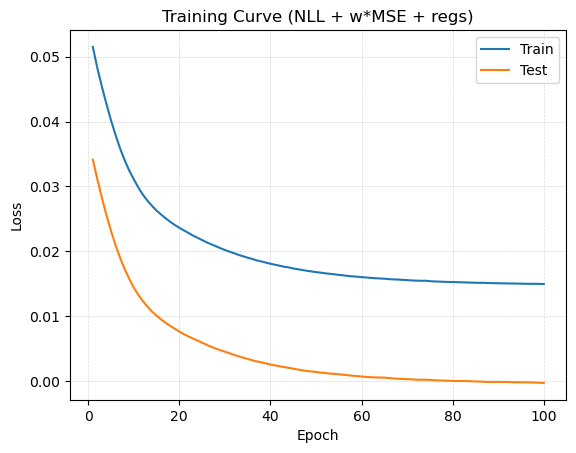


(3) 99% CI Coverage per state (test):
  state 0: 0.990
  state 1: 0.991


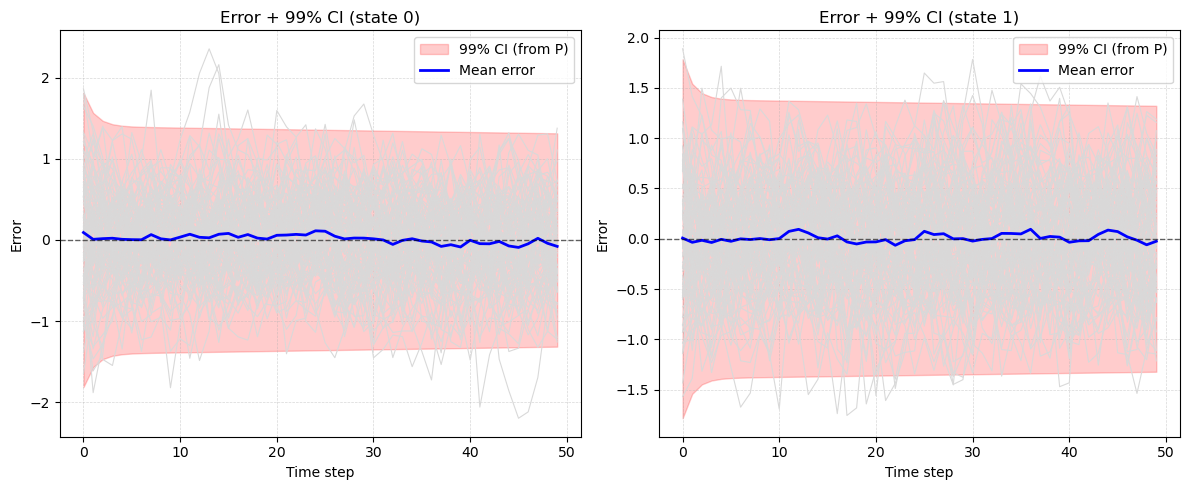

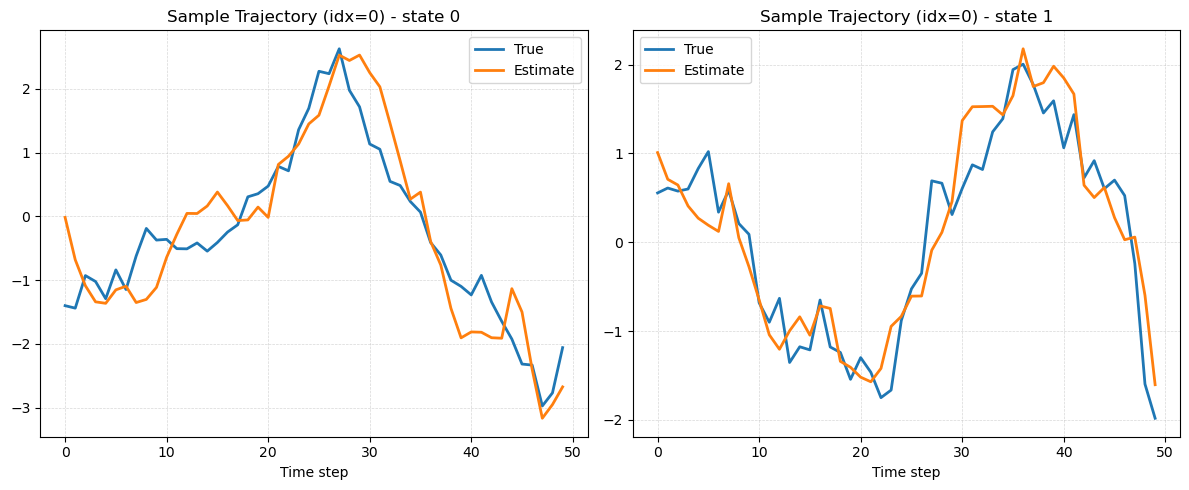

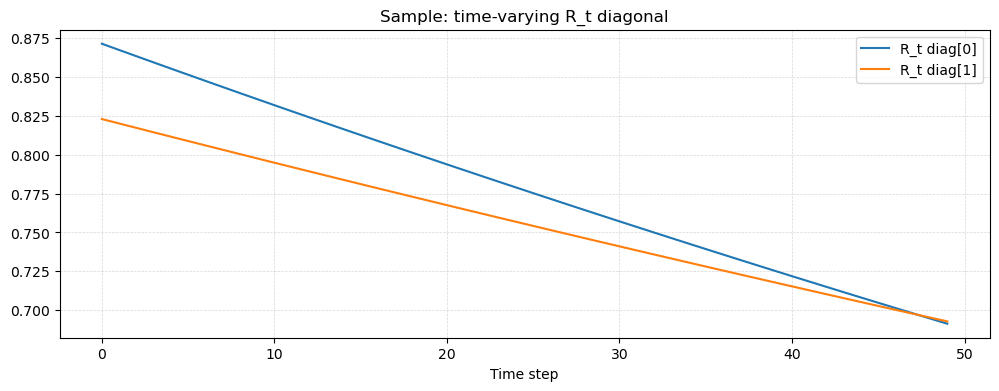

In [8]:
# =========================================================
# 6) Train / Test / Plots (applies 1,2,3)
# =========================================================
def train_linear_demo_apply_1_2_3():
    # ----------------------------
    # Data
    # ----------------------------
    nx, ny = 2, 2
    T = 50
    N_train, N_test = 500, 100

    dataset_all = LinearSystemDataset(T=T, N=N_train + N_test, nx=nx, ny=ny, q_scale=0.1, r_scale=1.0)
    F_sys, H_sys = dataset_all.F, dataset_all.H
    Q_true, R_true = dataset_all.Q_true, dataset_all.R_true

    X_train = dataset_all.X[:N_train]
    Y_train = dataset_all.Y[:N_train]
    X_test  = dataset_all.X[N_train:]
    Y_test  = dataset_all.Y[N_train:]

    # DataLoader (CPU -> GPU copy)
    train_loader = DataLoader(
        list(zip(X_train, Y_train)),
        batch_size=128,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )
    test_loader = DataLoader(
        list(zip(X_test, Y_test)),
        batch_size=256,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    # ----------------------------
    # Model
    # ----------------------------
    model = AdaptiveUKF_Qlearn_RtCholesky(
        nx=nx, ny=ny,
        F_sys=F_sys.to(device),
        H_sys=H_sys.to(device),
        Q_init=Q_true.to(device),   # 초기값은 true로 시작 (원하면 더 틀리게 시작해도 됨)
        R_init=R_true.to(device),
        ut_alpha=0.5, ut_beta=2.0, ut_kappa=0.0,
        hidden=64,
        delta_max=0.10,     # (2) delta 제한
        vec_clip=6.0,
        q_diag_eps=1e-6,
        r_diag_eps=1e-6
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

    # ----------------------------
    # Train
    # ----------------------------
    num_epochs = 100  # <<< epoch 늘리고 싶으면 여기!
    w_mse = 1
    lam_delta = 1e-2   # (2) delta reg weight
    lam_base  = 1e-3   # (2) base drift reg weight

    train_loss_hist = []
    test_loss_hist = []

    print("Training...")
    for epoch in range(num_epochs):
        model.train()
        running = 0.0
        count = 0

        for xb_cpu, yb_cpu in train_loader:
            xb = xb_cpu.to(device, non_blocking=True)
            yb = yb_cpu.to(device, non_blocking=True)
            B = xb.shape[0]

            x0 = torch.zeros(B, nx, device=device)
            P0 = torch.eye(nx, device=device).unsqueeze(0).expand(B, -1, -1).contiguous()

            optimizer.zero_grad(set_to_none=True)

            x_hat, P_hat, _, reg = model(yb, x0, P0)

            loss_main = nll_plus_mse(x_hat, xb, P_hat, w_mse=w_mse, eps=1e-8)
            loss = loss_main + lam_delta * reg["reg_delta"] + lam_base * reg["reg_base"]

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running += loss.item() * B
            count += B

        train_loss = running / count
        train_loss_hist.append(train_loss)

        # ---- Test loss
        model.eval()
        with torch.no_grad():
            running_t = 0.0
            count_t = 0
            for xb_cpu, yb_cpu in test_loader:
                xb = xb_cpu.to(device, non_blocking=True)
                yb = yb_cpu.to(device, non_blocking=True)
                B = xb.shape[0]
                x0 = torch.zeros(B, nx, device=device)
                P0 = torch.eye(nx, device=device).unsqueeze(0).expand(B, -1, -1).contiguous()

                x_hat, P_hat, _, reg = model(yb, x0, P0)
                loss_main = nll_plus_mse(x_hat, xb, P_hat, w_mse=w_mse, eps=1e-8)
                loss = loss_main + lam_delta * reg["reg_delta"] + lam_base * reg["reg_base"]
                running_t += loss.item() * B
                count_t += B
            test_loss = running_t / count_t

        test_loss_hist.append(test_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:03d} | Train Loss={train_loss:.6f} | Test Loss={test_loss:.6f}")

    # ----------------------------
    # Plot training curves
    # ----------------------------
    plt.figure()
    plt.plot(np.arange(1, num_epochs+1), train_loss_hist, label="Train")
    plt.plot(np.arange(1, num_epochs+1), test_loss_hist, label="Test")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Curve (NLL + w*MSE + regs)")
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    plt.legend()
    plt.show()

    # ----------------------------
    # Final evaluation on full test set + (3) 99% coverage
    # ----------------------------
    model.eval()
    with torch.no_grad():
        X_test_gpu = X_test.to(device)
        Y_test_gpu = Y_test.to(device)

        B = X_test_gpu.shape[0]
        x0 = torch.zeros(B, nx, device=device)
        P0 = torch.eye(nx, device=device).unsqueeze(0).expand(B, -1, -1).contiguous()

        x_hat, P_hat, Rdiag_hist, _ = model(Y_test_gpu, x0, P0)

        cov99 = coverage_99(x_hat, X_test_gpu, P_hat)
        print("\n(3) 99% CI Coverage per state (test):")
        for i in range(nx):
            print(f"  state {i}: {cov99[i]:.3f}")

        # ----------------------------
        # Plot: all errors (light gray) + mean error (blue) + 99% CI band (red)
        # ----------------------------
        z = 2.5758293035489004
        err = (X_test_gpu - x_hat).cpu().numpy()                  # [B,T,nx]
        Pdiag = torch.diagonal(P_hat, dim1=-2, dim2=-1).cpu().numpy()  # [B,T,nx]
        mean_err = err.mean(axis=0)                               # [T,nx]
        mean_std = np.sqrt(np.maximum(Pdiag.mean(axis=0), 1e-12)) # [T,nx]
        ci = z * mean_std
        t = np.arange(T)

        plt.figure(figsize=(12, 5))
        for i in range(nx):
            plt.subplot(1, nx, i+1)

            # all trajectories in light gray
            for b in range(err.shape[0]):
                plt.plot(t, err[b, :, i], color="0.85", linewidth=0.8)

            # CI band around 0
            plt.fill_between(t, -ci[:, i], ci[:, i], alpha=0.20, color="red", label="99% CI (from P)")

            # mean error
            plt.plot(t, mean_err[:, i], color="blue", linewidth=2.0, label="Mean error")

            plt.axhline(0.0, color="black", linestyle="--", linewidth=1.0, alpha=0.6)
            plt.title(f"Error + 99% CI (state {i})")
            plt.xlabel("Time step")
            plt.ylabel("Error")
            plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
            plt.legend()

        plt.tight_layout()
        plt.show()

        # ----------------------------
        # Plot: one sample trajectory (true vs estimate)
        # ----------------------------
        idx = 0
        x_true_1 = X_test_gpu[idx].cpu().numpy()   # [T,nx]
        x_hat_1  = x_hat[idx].cpu().numpy()
        plt.figure(figsize=(12, 5))
        for i in range(nx):
            plt.subplot(1, nx, i+1)
            plt.plot(t, x_true_1[:, i], label="True", linewidth=2.0)
            plt.plot(t, x_hat_1[:, i],  label="Estimate", linewidth=2.0)
            plt.title(f"Sample Trajectory (idx={idx}) - state {i}")
            plt.xlabel("Time step")
            plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
            plt.legend()
        plt.tight_layout()
        plt.show()

        # (optional) show R_t diagonal evolution for sample
        Rdiag_1 = Rdiag_hist[idx].cpu().numpy()    # [T,ny]
        plt.figure(figsize=(12, 4))
        for j in range(ny):
            plt.plot(t, Rdiag_1[:, j], label=f"R_t diag[{j}]")
        plt.title("Sample: time-varying R_t diagonal")
        plt.xlabel("Time step")
        plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
        plt.legend()
        plt.show()

    return model


if __name__ == "__main__":
    train_linear_demo_apply_1_2_3()